Источник: https://stepik.org/lesson/532600/step/1?auth=login&unit=717336

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

import seaborn as sns

from google.colab import drive
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random

# Загрузка данных

In [2]:
drive.mount("/content/Drive")
path_to_folder = os.path.join("Drive", "MyDrive", "data")

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [15]:
list_of_filenames = os.listdir(path_to_folder)
#random.shuffle(list_of_filenames)

In [6]:
len(list_of_filenames_train)

106

In [56]:
def make_patches(voltage, labels, patch_len = 40, stride = 1):
  voltage_patches = []
  length = len(voltage)
  length = length - (length % patch_len)
  for i in range(0, length, stride):
    v_p = voltage[i:i+patch_len]
    l_p = labels[i:i+patch_len]
    if sum(l_p) == 0 and len(l_p) == patch_len:
      voltage_patches.append(v_p)
  return voltage_patches

In [8]:
def load_group(list_of_filenames, path_to_folder):
  all_voltage_patches = []
  for filename in list_of_filenames:
    path_to_file = os.path.join(path_to_folder, filename)
    data = pd.read_csv(path_to_file)
    voltage = torch.tensor(data['Voltage'].values, dtype=torch.float32)
    training_mean = voltage.mean()
    training_std = voltage.std()
    voltage = (voltage - training_mean) / training_std
    labels = data['labels'].to_numpy()
    voltage_patches = make_patches(voltage, labels)
    all_voltage_patches += voltage_patches
  return all_voltage_patches

In [128]:
X = load_group([list_of_filenames[3]], path_to_folder)


In [127]:
list_of_filenames[3]

'01122020_Block4_labels.txt'

In [129]:
X = torch.stack(X).unsqueeze(1)

In [130]:
x_train, x_val = train_test_split(X, train_size=0.9, shuffle=False)
print("Training input shape: ", x_train.shape)

Training input shape:  torch.Size([462164, 1, 100])


In [131]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=64)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=64)

# Модель

In [92]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

# Обучение

In [132]:
n_epochs = 2
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/2 [00:00<?, ?it/s]

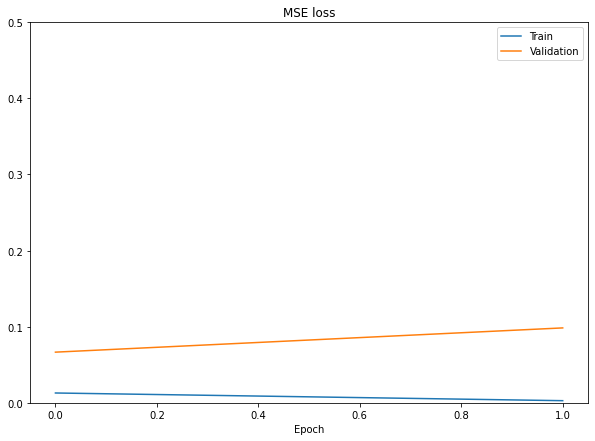

In [133]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.5)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

# Детекция аномалий

In [134]:
X_loader = torch.utils.data.DataLoader(X, batch_size=1)
model.eval()
threshold = 0.0
x_pred = []

with torch.no_grad():
  for batch in X_loader:
    pred = model(batch.to(device)).cpu().numpy()
    x_pred.append(pred.ravel())
    mae_loss = np.mean(np.abs(pred - batch.numpy()))

    if mae_loss > threshold:
      threshold = mae_loss

print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.4304438


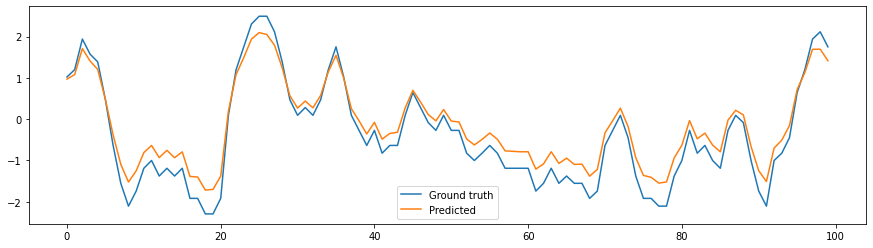

In [135]:
plt.figure(figsize=(15, 4))
plt.plot(x_train[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

# Детекция на тестовых данных

In [97]:
def make_test_patches(voltage, labels, patch_len = 40, stride = 1):
  voltage_patches = []
  length = len(voltage)
  length = length - (length % patch_len)
  for i in range(0, length, stride):
    v_p = voltage[i:i+patch_len]
    l_p = labels[i:i+patch_len]
    if len(l_p) == patch_len:
      voltage_patches.append(v_p)
  return voltage_patches

In [83]:
def load_test_group(list_of_filenames, path_to_folder):
  all_voltage_patches = []
  for filename in list_of_filenames:
    path_to_file = os.path.join(path_to_folder, filename)
    data = pd.read_csv(path_to_file)
    voltage_pandas = data['Voltage']
    voltage = torch.tensor(data['Voltage'].values, dtype=torch.float32)
    training_mean = voltage.mean()
    training_std = voltage.std()
    voltage = (voltage - training_mean) / training_std
    labels = data['labels'].to_numpy()
    voltage_patches = make_test_patches(voltage, labels)
    all_voltage_patches += voltage_patches
  return voltage_pandas, all_voltage_patches

In [136]:
voltage_test, x_test = load_test_group([list_of_filenames[3]], path_to_folder)
x_test = torch.stack(x_test).unsqueeze(1)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print("Test input shape: ", x_test.shape)

Test input shape:  torch.Size([518097, 1, 40])


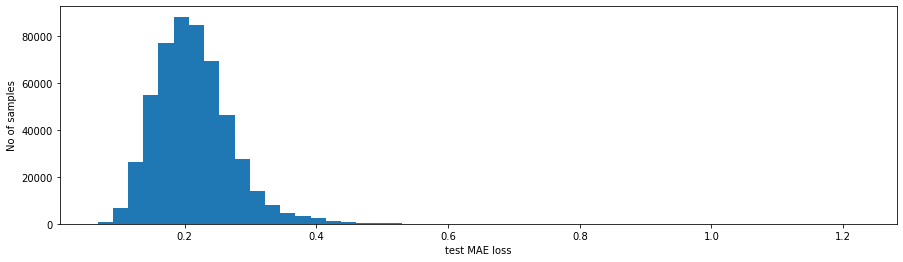

Number of anomaly samples:  2504
Indices of anomaly samples:  (array([   101,    102,    103, ..., 517833, 517834, 517835]),)


In [137]:
# Get test MAE loss.

test_losses = []
with torch.no_grad():
  for batch in test_loader:
    pred = model(batch.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - batch.numpy()))
    test_losses.append(mae_loss)

test_losses = np.array(test_losses).reshape((-1))

plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

# Графики аномалий

In [151]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
PATCH_LEN = 30
anomalous_data_indices = []
for data_idx in range(PATCH_LEN - 1, len(voltage_test) - PATCH_LEN + 1):
    if np.all(anomalies[data_idx - PATCH_LEN + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [152]:
len(anomalous_data_indices)

310

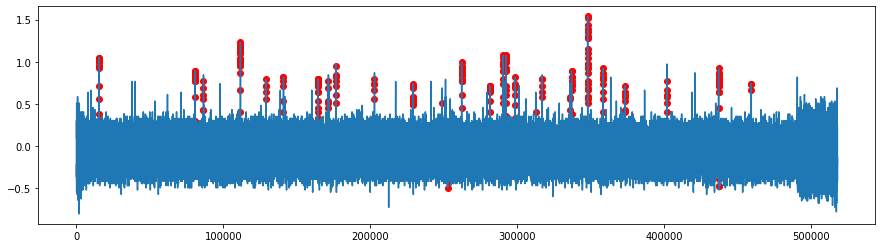

In [153]:
df_subset = voltage_test.iloc[anomalous_data_indices].to_frame()
fig, ax = plt.subplots(figsize=(15, 4))
voltage_test.plot(legend=False, ax=ax)
plt.scatter(x = df_subset.index, y = df_subset['Voltage'], color="r")
#df_subset.plot(y = df_subset.index, legend=False, ax=ax, color="r", kind='scatter')
plt.show()

In [124]:
df_subset['Voltage']

18841     2.384356
18842     2.410722
18843     2.461807
18844     2.565625
18845     2.590343
            ...   
578317    1.482955
578318    1.458237
578319    1.354419
578320    1.174798
578321    1.070980
Name: Voltage, Length: 322, dtype: float64